The purpose of this project is to build a model using linear regression to explain the variation in premature age-adjusted mortality rate (frequency of deaths under the age of 75) across the United States using a variety of demographic and health-related variables. 

The approach I took was to use 22 potential explanatory variables (based on DATAUSA) , fit a linear regression model to the data, and determined which variables were "significant" using p-values with a cut-off of 5%. The coefficients of the resulting OLS model gives information about how a particular risk factor (e.g. Diabetes Rate or Drug Overdose Death Rate in a population) contributes to the overall premature mortality rate in the U.S. population.

In [1]:
# change root directory to location of DATAUSA datasets

import os
os.chdir('C:\\users\\sarva\\projects\\datasets\\datausa')

In [2]:
# import all variable datasets

import pandas as pd

variable_list = dict()
values = []

for filename in os.listdir():
    len_extension = len('.csv')
    len_filename = len(filename)
    
    dataset_name = filename[0:(len_filename - len_extension)]
    dataset = pd.read_csv(filename)
    
    variable_list.update({dataset_name: dataset})
    
variable_names = list(variable_list.keys())
datasets = list(variable_list.values())

# group each county by mean across all years for each variable


for i in range(0, len(datasets)):
    datasets[i] = datasets[i].groupby(['geo_name'])[datasets[i].columns[4]].mean()
    
# fill all N/A values with mean value across all counties for that variable
    
for i in range(0, len(datasets)):
    datasets[i] = datasets[i].fillna(datasets[i].mean())
    datasets[i] = datasets[i].to_frame().reset_index()
    datasets[i].columns = ['county', variable_names[i]]
    datasets[i].set_index('county')

print(variable_names)

['adult_smoking_rate', 'ambulatory_discharge_rate', 'citizenship_rate', 'diabetes_rate', 'drug_overdose_death_rate', 'high_school_grad_rate', 'HIV_rate', 'homeownership_rate', 'income_inequality', 'infant_mortality_rate', 'median_age', 'median_hh_income', 'median_home_value', 'obesity_rate', 'population', 'poverty_rate', 'premature_mortality_rate', 'rural_pop_percent', 'teen_birth_rate', 'traffic_death_rate', 'unemp_rate', 'uninsured_adult_rate', 'uninsured_children_rate', 'uninsured_rate', 'violent_crime_rate']


In [16]:
# create dataset with all variable values

from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()

allvar = datasets[0]

county_name = []
state = []

for i in range(0, len(datasets)):
        allvar = pd.merge(allvar, datasets[i])
           
allvar = allvar.set_index('county')

allvar = allvar.drop(['District of Columbia, DC'])

county = allvar.index

county_state_split = county.str.split(',')

for i in county_state_split:
    county_name.append(i[0])
    state.append(i[1].strip())        
    
allvar['state'] = state

allvar = allvar[['state', 'adult_smoking_rate', 'ambulatory_discharge_rate',
       'citizenship_rate', 'diabetes_rate', 'drug_overdose_death_rate',
       'high_school_grad_rate', 'HIV_rate', 'homeownership_rate',
       'income_inequality', 'infant_mortality_rate', 'median_age',
       'median_hh_income', 'median_home_value', 'obesity_rate', 'population',
       'poverty_rate', 'premature_mortality_rate', 'rural_pop_percent',
       'teen_birth_rate', 'traffic_death_rate', 'unemp_rate',
       'uninsured_adult_rate', 'uninsured_children_rate', 'uninsured_rate',
       'violent_crime_rate']]
        
input_var = allvar.drop(['state','premature_mortality_rate','uninsured_adult_rate','uninsured_children_rate'], axis=1)

# input_var_scaled = pd.DataFrame(scaler.fit_transform(input_var))

target_names = list(input_var.columns)

In [17]:
# split input dataset into training and test set

from sklearn.model_selection import train_test_split

X = np.array(input_var)
y = np.array(allvar['premature_mortality_rate'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.80, random_state=42, stratify=allvar[['state']])

In [18]:
import statsmodels.api as sm

model = sm.OLS(y, X).fit()

model_coef = model.params

# print("R-squared value: {:.3f}".format(model.score(X_test, y_test)))

In [24]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                 1.266e+04
Date:                Tue, 26 Mar 2019   Prob (F-statistic):               0.00
Time:                        03:08:40   Log-Likelihood:                -16183.
No. Observations:                3132   AIC:                         3.241e+04
Df Residuals:                    3110   BIC:                         3.254e+04
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           394.9273     30.966     12.753      0.0

In [25]:
uninsured_rate_coef = model_coef[target_names.index('uninsured_rate')]

attribute_base = [100, 1000, 100, 100, 100000, 100, 100000, 100, 1, 1000, 1, 1, 1, 100, 1, 100, 100, 1000, 
                  100000, 100, 100, 100000]

model_coefficients = pd.DataFrame(model_coef, target_names)

model_coefficients_normalized = model_coefficients.copy()

for i in range(0,len(model_coefficients)):
    model_coefficients_normalized[0][i] = model_coefficients_normalized[0][i] / (100000/attribute_base[i])

    
model_coefficients_normalized = model_coefficients_normalized.drop(['income_inequality', 'median_age', 
                                                                    'median_hh_income', 'median_home_value', 
                                                                    'population'], axis=0)    


pd.options.display.float_format = '{:,.4f}'.format

print(model_coefficients_normalized)

target_coef = model_coefficients_normalized.loc['uninsured_rate'][0]

                                0
adult_smoking_rate         0.3949
ambulatory_discharge_rate  0.0040
citizenship_rate           0.2919
diabetes_rate              1.1438
drug_overdose_death_rate   2.2899
high_school_grad_rate     -0.0609
HIV_rate                   0.0069
homeownership_rate        -0.1481
infant_mortality_rate      0.0180
obesity_rate              -0.0636
poverty_rate              -0.0804
rural_pop_percent         -0.0037
teen_birth_rate            0.0132
traffic_death_rate         2.0127
unemp_rate                 0.2216
uninsured_rate            -0.0303
violent_crime_rate         0.0171


In [21]:
sum(dataset.groupby('geo_name').nunique()['geo_name'])

3138

Text(0,0.5,'Premature Deaths per 100,000')

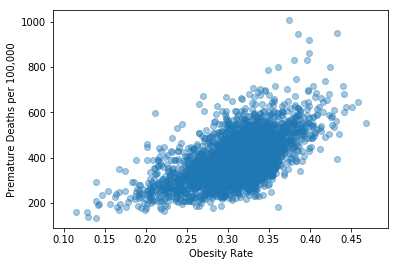

In [26]:
import matplotlib.pyplot as plt

plt.scatter(allvar['obesity_rate'], allvar['premature_mortality_rate'], alpha=0.4, marker='o')
plt.xlabel("Obesity Rate")
plt.ylabel("Premature Deaths per 100,000")

In [10]:
model2 = sm.OLS(allvar['premature_mortality_rate'], allvar['obesity_rate']).fit()

In [11]:
print(model2.summary())

                               OLS Regression Results                               
Dep. Variable:     premature_mortality_rate   R-squared:                       0.961
Model:                                  OLS   Adj. R-squared:                  0.961
Method:                       Least Squares   F-statistic:                 7.622e+04
Date:                      Mon, 25 Mar 2019   Prob (F-statistic):               0.00
Time:                              17:47:04   Log-Likelihood:                -18177.
No. Observations:                      3132   AIC:                         3.636e+04
Df Residuals:                          3131   BIC:                         3.636e+04
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------